### A logistic regression model to predict the artist (Modest Mouse or Violent Femmes) by a snippet of lyrics:

In [1]:
# import libraries:
import requests
import re
import pandas as pd
import time
import glob
import os
import seaborn as sns
import numpy as np

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

#### scraping a list of songs for the artists:

In [2]:
# get linkslist from URL, save as html to disk and return as text file: 

def get_linklist__to_disk(URL:str, html_filename:str):
    
    """scrape linklist from url, 
       save html.file to disk, returns textfile of html"""
    
    response= requests.get(URL)
    html_file = response.text
    print(response.status_code)
    
    with open(f'{html_filename}.html', 'w') as file:
        file.write(html_file)
    return html_file 

In [3]:
# get linklist for modest mouse, save to disk and return as text_file :

modest_html = get_linklist__to_disk("https://www.lyrics.com/artist/Modest-Mouse/200044", "modest")

200


In [4]:
# get linklist for violent femmes, save to disk and return as text_file :

violent_html = get_linklist__to_disk("https://www.lyrics.com/artist/Violent-Femmes/5767", "violent")

200


#### extract songlinks  with regEx/BeautifulSoup, complete URL and check for duplicates: 

#### Violent femmes

In [5]:
# RegEx pattern:
pattern_vf = 'href="(\/lyric.+?)"' 

In [6]:
def linklist_url_complete(pattern, textfilename):
    
    """ returns list with complete URLs of songlinks,
        textfilename can be output of get_linklist_to_disk"""
    
    songlist = re.findall(pattern, textfilename)
    complete =[]
    
    # complete links in list with missing URL part:
    for link in songlist: 
        complete.append("https://www.lyrics.com" + link)
    return complete

In [7]:
songs_vf = linklist_url_complete(pattern_vf, violent_html)

In [8]:
# check for duplicate files:                                                    
def check_dupes(linklist):

    s = set()
    for item in linklist:
        s.add(item)
    if (len(linklist)-(len(s)) == 0):
                         print("no duplicates")
    else:
                         print("duplicates found")
   

In [9]:
check_dupes(songs_vf)

no duplicates


#### Modest Mouse  - same procedure as above but using BeautifulSoup

In [10]:
#create beautiful soup object:
modest_soup = BeautifulSoup(modest_html, 'html.parser')

In [14]:
# parser:
parser = "soup.find_all(attrs = {'class' : 'tdata-ext'})[0].find_all('tr')"

In [18]:
# create list with complete song links (excluding album links) with beautiful soup:
def linklist_complete_BS(parser:str):
    
    """ get complete URL for MM songs scraped at lyrics.com"""
    songs = []    
    for element in parser:      
   
        try:
            songs.append(element.a.get('href'))
       
        except AttributeError:
            pass
    
    complete =[]
    for link in songs: 
        complete.append("https://www.lyrics.com" + link)
    return complete

In [19]:
songs_mm = linklist_complete_BS(parser)

In [20]:
# check for duplicate files    
check_dupes(songs_mm)

no duplicates


#### get html files for each song

In [21]:
# write function to request all html files in songlink-list and download as html files to disk: 
def get_songs_html(linklist, artist:str, artistinitials:str):
    """scrapes and writes html file for each songlyric to disk"""

    num = 1
    for link in linklist:
    
        response = requests.get(link)
        song_html = response.text
        with open(f'/Users/krystanafoh/lyrics/{artist}/{num}_{artistinitials}_test.html', 'w') as file:
            file.write(song_html)
        num = num + 1
        time.sleep(0.3)

In [ ]:
# violent femmes:
#get_songs_html(songs_vf, "violentfemmes", "vf")

In [ ]:
# modest mouse:
#get_songs_html(songs_mm, "modestmouse", "mm")

####  extract songlyrics of html files and safe each to textfile: 

In [22]:
def lyrics_to_text(linklist, artist:str, artistinitials:str):
    """extract and safe lyrics of each song to textfile"""
    
    num = 1
    for i in range(len(linklist)):
        
        filename = (f'/Users/krystanafoh/lyrics/{artist}/{num}_{artistinitials}')
# open html file
        html = open(f'{filename}.html')
# create beautiful soup object
        soup = BeautifulSoup(html, 'html.parser')
# get song text
        text = soup.find_all('pre', attrs = {'class' : 'lyric-body'})[0].get_text()
# safe song text to text file: 
        with open(f'{filename}.text', 'w') as file:
            file.write(text)
        num = num + 1

In [ ]:
# modest mouse:
#lyrics_to_text(songs_mm, "modestmouse", "mm")

In [ ]:
# violent femmes: 
#lyrics_to_text(songs_vf, "violentfemmes", "vf")

#### create lists of strings for each band

In [23]:
def lyrics_to_list(path:str):
    """returns a list of lyricstrings"""

    textfile = glob.glob(os.path.join(path, '*.text'), recursive=False)

    lyrics = []
   
    for file_path in textfile:
        with open(file_path) as f_input:
            lyrics.append(f_input.read())

    return lyrics

In [24]:
# create list of Modest Mouse songtexts: 
path = '/Users/krystanafoh/lyrics/modestmouse/'
list_mm = lyrics_to_list(path)
len(list_mm)

402

In [25]:
# create list of Violent Femmes songtexts: 
path2 = '/Users/krystanafoh/lyrics/violentfemmes/'
list_vf = lyrics_to_list(path2)
len(list_vf)

386

#### create corpus and do test-train-split

In [26]:
CORPUS = list_mm + list_vf

In [27]:
len(CORPUS)

788

In [28]:
labels = ["Modest Mouse"] * len(list_mm) + ["Violent Femmes"] * len(list_vf)

In [29]:
X = CORPUS
y = labels

In [30]:
# train-test-split: 
X_test, X_train, y_test, y_train = train_test_split(X, y, stratify=y, random_state=42)

####  Feature Engineering: 

In [31]:
def clean_text(text):
    
    """cleans up text with RegEx, replacing "n'" with "ng", 
    removing punctuation except "'", replaceing "\n" with whitespace, lowercaseing, 
    removing double whitespace"""
    
    # replace "n'" with ng:
    
    text = re.sub("(\w(n')\s)","ng",text)        
    
    #remove punctuation:
    text = re.sub("[^\w\s']","",text)
    
    # replace "\n" by whitespace : 
    text = re.sub("\\n", " ", text)
    
   
    # lowercase    
    text = text.lower()
    
    #removing duble whitespaces:
    text = re.sub("\s+"," ", text)
    
    return text


In [32]:
def clean_list(X_split):
    """applies clean_text function to every item in list (of songtexts)"""
    
    clean_list = []
    for song in X_split:
        clean_list.append(clean_text(song))
    return clean_list

In [33]:
checkout = clean_list(X_train)

#### create pipeline

In [34]:
clean_lr_pipe = Pipeline([
    ("cleaning_text", FunctionTransformer(clean_list)),
    ("vectorize", TfidfVectorizer(ngram_range=(1,1), smooth_idf=True, stop_words='english')),
    ("model", LogisticRegression())
    
])

####  X train fit and evaluation of model: 

In [35]:
# fit pipeline on X_train: 
clean_lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('cleaning_text',
                 FunctionTransformer(func=<function clean_list at 0x11cb5b0d0>)),
                ('vectorize', TfidfVectorizer(stop_words='english')),
                ('model', LogisticRegression())])

In [36]:
# make predictions on X_train: 
y_pred_train = clean_lr_pipe.predict(X_train)

#### evaluation: 

In [37]:
#classification report: 
print(classification_report(y_train,y_pred_train))

                precision    recall  f1-score   support

  Modest Mouse       0.99      1.00      1.00       101
Violent Femmes       1.00      0.99      0.99        96

      accuracy                           0.99       197
     macro avg       1.00      0.99      0.99       197
  weighted avg       0.99      0.99      0.99       197



In [38]:
# training score: 
clean_lr_pipe.score(X_train, y_train)

0.9949238578680203

In [39]:
# cross-validation: 
cross_val_score(clean_lr_pipe, X_train, y_train, cv=20).mean()

0.8255555555555555

<AxesSubplot:>

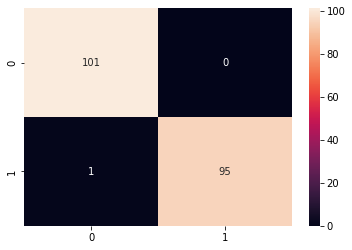

In [40]:
# confusion matrix: 
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt=".0f")

####  predictions on X_test and further evaluations: 

In [41]:
# predict on  X_test: 
y_pred_test = clean_lr_pipe.predict(X_test)

In [42]:
print(classification_report(y_test,y_pred_test))

                precision    recall  f1-score   support

  Modest Mouse       0.80      0.97      0.88       301
Violent Femmes       0.96      0.75      0.84       290

      accuracy                           0.86       591
     macro avg       0.88      0.86      0.86       591
  weighted avg       0.88      0.86      0.86       591



In [43]:
# test score: 
clean_lr_pipe.score(X_test, y_test)

0.8646362098138748

In [44]:
# cross-validation: 
cross_val_score(clean_lr_pipe, X_train, y_train, cv=20).mean()

0.8255555555555555

<AxesSubplot:>

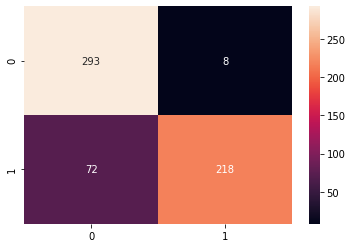

In [45]:
# confusion matrix:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt=".0f")

#### pipeline predictions on guessed band lyrics: 

In [46]:
clean_lr_pipe.predict_proba(["float on"]) 

array([[0.67100283, 0.32899717]])

In [47]:
clean_lr_pipe.predict_proba(["getting together with you"])

array([[0.4489732, 0.5510268]])

In [48]:
clean_lr_pipe.predict_proba(["like a blister in the sun"])

array([[0.46686633, 0.53313367]])

In [49]:
clean_lr_pipe.predict_proba(["nightmares"])

array([[0.45007347, 0.54992653]])